In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Folder Path on Google Drive
folder_path = "/content/drive/MyDrive/Colab/NU/IE6200/trip_data/"

# Get all CSV files in the folder
csv_files = glob.glob(folder_path + "*.csv")

# Initialize an empty list to store dataframes
dfs = []

# Loop over each file with tqdm progress bar, load it, rename columns, and append to the list
for file in tqdm(csv_files, desc="Loading and Processing CSV Files"):
    df = pd.read_csv(file)
    # Rename the columns
    df = df.rename(columns={
        "member_casual": "rider_type",
        "rideable_type": "bike_type"
    })
    # Append to the list of dataframes
    dfs.append(df)

# Combine all dataframes into one
all_df = pd.concat(dfs, ignore_index=True)

# Sort the combined DataFrame by "started_at" column
all_df = all_df.sort_values(by="started_at").reset_index(drop=True)

Loading and Processing CSV Files: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


In [3]:
all_df.shape

(3768997, 13)

In [4]:
# Assign combined_df as a deep copy of all_df
combined_df = all_df.copy()

In [5]:
combined_df.dtypes

,0
ride_id,object
bike_type,object
started_at,object
ended_at,object
start_station_name,object
start_station_id,object
end_station_name,object
end_station_id,object
start_lat,float64
start_lng,float64


In [6]:
# Convert the datetime columns to strings and check for fractional seconds
fractional_seconds = combined_df[combined_df["started_at"].astype(str).str.contains(r"\.\d+")]
if fractional_seconds.empty:
    print("No rows with fractional seconds found.")
else:
    print(fractional_seconds[["started_at", "ended_at"]].head())

No rows with fractional seconds found.


In [7]:
combined_df

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type
0,31F12D722DEC2205,classic_bike,2023-12-01 00:00:47,2023-12-01 00:18:32,MIT Carleton St at Amherst St,M32070,Lower Cambridgeport at Magazine St / Riverside Rd,M32022,42.360541,-71.086698,42.357219,-71.113872,member
1,C7B5105B0B65C0F3,classic_bike,2023-12-01 00:02:04,2023-12-01 00:07:54,MIT at Mass Ave / Amherst St,M32006,MIT Vassar St,M32042,42.358100,-71.093198,42.355601,-71.103945,member
2,68B5F2A512F98D31,classic_bike,2023-12-01 00:02:11,2023-12-01 00:03:15,South Station - 700 Atlantic Ave,A32010,Boston Landing,A32045,42.352175,-71.055547,42.356561,-71.141675,member
3,498C4A8C729ED986,classic_bike,2023-12-01 00:04:19,2023-12-01 00:14:00,One Beacon St,B32061,Columbus Ave at W. Canton St,C32077,42.358477,-71.061351,42.344742,-71.076482,member
4,2B9A06F84509E2C0,classic_bike,2023-12-01 00:04:38,2023-12-01 00:16:16,Silber Way,D32032,Dartmouth St at Newbury St,D32045,42.349495,-71.100575,42.350961,-71.077828,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768992,CAFEFEAE3D7AE834,classic_bike,2024-09-30 23:49:00,2024-09-30 23:53:00,Salem MBTA - Washington at Federal St,T32005,Salem MBTA - Washington at Federal St,T32005,42.523452,-70.896111,42.523452,-70.896111,casual
3768993,D957C36838AABB68,classic_bike,2024-09-30 23:50:00,2024-09-30 23:55:00,O'Brien Highway at First Street,M32090,Bunker Hill Community College,A32023,42.370982,-71.076638,42.374090,-71.069060,member
3768994,C012246BC8E33C8D,classic_bike,2024-09-30 23:50:00,2024-09-30 23:51:00,Commonwealth Ave at Agganis Way,A32002,Commonwealth Ave At Babcock St,K32006,42.351692,-71.119035,42.351547,-71.121262,member
3768995,255114DE04B91E31,electric_bike,2024-09-30 23:51:00,2024-09-30 23:58:00,Brighton Ave at Linden St,D32058,Brookline Town Hall,K32005,42.352838,-71.129675,42.333765,-71.120464,member


In [8]:
# Convert started_at and ended_at columns to datetime
combined_df["started_at"] = pd.to_datetime(combined_df["started_at"], errors='coerce')
combined_df["ended_at"] = pd.to_datetime(combined_df["ended_at"], errors='coerce')

# Check the data types after conversion
combined_df[["started_at", "ended_at"]].dtypes

,0
started_at,datetime64[ns]
ended_at,datetime64[ns]


In [9]:
# Identify rows where conversion to datetime failed
invalid_dates = combined_df[combined_df["started_at"].isna() | combined_df["ended_at"].isna()]
if invalid_dates.empty:
    print("No invalid dates found.")
else:
    # Display rows with invalid dates
    print(invalid_dates[["started_at", "ended_at"]].head())

No invalid dates found.


In [10]:
combined_df.shape

(3768997, 13)

In [11]:
# Missing values
missing_values = combined_df.isnull().sum()
missing_values

,0
ride_id,0
bike_type,0
started_at,0
ended_at,0
start_station_name,1060
start_station_id,1060
end_station_name,7026
end_station_id,7175
start_lat,0
start_lng,0


In [12]:
# Remove rows with any missing values
combined_df = combined_df.dropna()

In [13]:
combined_df.head()

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type
0,31F12D722DEC2205,classic_bike,2023-12-01 00:00:47,2023-12-01 00:18:32,MIT Carleton St at Amherst St,M32070,Lower Cambridgeport at Magazine St / Riverside Rd,M32022,42.360541,-71.086698,42.357219,-71.113872,member
1,C7B5105B0B65C0F3,classic_bike,2023-12-01 00:02:04,2023-12-01 00:07:54,MIT at Mass Ave / Amherst St,M32006,MIT Vassar St,M32042,42.358100,-71.093198,42.355601,-71.103945,member
2,68B5F2A512F98D31,classic_bike,2023-12-01 00:02:11,2023-12-01 00:03:15,South Station - 700 Atlantic Ave,A32010,Boston Landing,A32045,42.352175,-71.055547,42.356561,-71.141675,member
3,498C4A8C729ED986,classic_bike,2023-12-01 00:04:19,2023-12-01 00:14:00,One Beacon St,B32061,Columbus Ave at W. Canton St,C32077,42.358477,-71.061351,42.344742,-71.076482,member
4,2B9A06F84509E2C0,classic_bike,2023-12-01 00:04:38,2023-12-01 00:16:16,Silber Way,D32032,Dartmouth St at Newbury St,D32045,42.349495,-71.100575,42.350961,-71.077828,member


In [14]:
# Most/least popular stations
combined_df["start_station_name"].value_counts()

,count
start_station_name,
MIT at Mass Ave / Amherst St,69503
Central Square at Mass Ave / Essex St,56334
Harvard Square at Mass Ave/ Dunster,49570
MIT Pacific St at Purrington St,39844
Charles Circle - Charles St at Cambridge St,39659
...,...
Winthrop Circle,11
Damrell st at Old Colony Ave,6
Chestnut Hill Ave. at Ledgemere Road,5


In [15]:
def validate_station_mappings(dataframe):
    """
    Validate Station Name-to-ID mappings for both start and end stations.

    This function checks for inconsistencies between station names and station IDs by identifying
    cases where a station name is associated with multiple station IDs or where a station ID is
    associated with multiple station names. The results are printed to the console.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing bike trip data with station names and IDs.
    """

    # Create dictionaries to map start station names to IDs and start station IDs to names
    start_name_to_ids = dataframe.groupby("start_station_name")["start_station_id"].unique().to_dict()
    start_id_to_names = dataframe.groupby("start_station_id")["start_station_name"].unique().to_dict()

    # Create dictionaries to map end station names to IDs and end station IDs to names
    end_name_to_ids = dataframe.groupby("end_station_name")["end_station_id"].unique().to_dict()
    end_id_to_names = dataframe.groupby("end_station_id")["end_station_name"].unique().to_dict()

    # Check for mismatches in start stations (name to multiple IDs)
    print("Start Station Names Mapping to Multiple IDs:")
    if any(len(ids) > 1 for ids in start_name_to_ids.values()):
        for name, ids in start_name_to_ids.items():
            if len(ids) > 1:
                print(f"{name}: {list(ids)} (Instances: {len(ids)})")
    else:
        print("nil")

    # Check for mismatches in start stations (ID to multiple names)
    print("\nStart Station IDs Mapping to Multiple Names:")
    if any(len(names) > 1 for names in start_id_to_names.values()):
        for station_id, names in start_id_to_names.items():
            if len(names) > 1:
                print(f"{station_id}: {list(names)} (Instances: {len(names)})")
    else:
        print("nil")

    # Check for mismatches in end stations (name to multiple IDs)
    print("\nEnd Station Names Mapping to Multiple IDs:")
    if any(len(ids) > 1 for ids in end_name_to_ids.values()):
        for name, ids in end_name_to_ids.items():
            if len(ids) > 1:
                print(f"{name}: {list(ids)} (Instances: {len(ids)})")
    else:
        print("nil")

    # Check for mismatches in end stations (ID to multiple names)
    print("\nEnd Station IDs Mapping to Multiple Names:")
    if any(len(names) > 1 for names in end_id_to_names.values()):
        for station_id, names in end_id_to_names.items():
            if len(names) > 1:
                print(f"{station_id}: {list(names)} (Instances: {len(names)})")
    else:
        print("nil")

# Call the function with your DataFrame
validate_station_mappings(combined_df)

Start Station Names Mapping to Multiple IDs:
Somerville Hospital: ['S32020', 'S32052'] (Instances: 2)
Tremont St at Court St: ['A32046', 'A32058'] (Instances: 2)

Start Station IDs Mapping to Multiple Names:
A32046: ['Tremont St at Court St', 'Canal St. at Causeway St.', 'Canal St at Causeway St'] (Instances: 3)
A32058: ['Tremont St. at Court St.', 'Tremont St at Court St'] (Instances: 2)
B32038: ['Chestnut Hill Ave. at Ledgemere Road', 'Chestnut Hill Ave at Ledgemere Rd'] (Instances: 2)
C32109: ['Centre St. at Allandale St.', 'Centre St at Allandale St'] (Instances: 2)
E32003: ['Hyde Square - Barbara St at Centre St', 'Hyde Square - Centre St at Perkins St'] (Instances: 2)
L32007: ['Swan Pl. at Minuteman Bikeway', 'Swan Place at Minuteman Bikeway'] (Instances: 2)
M32019: ['CambridgeSide Galleria - CambridgeSide PL at Land Blvd', 'Cambridgeside Pl at Land Blvd'] (Instances: 2)
S32052: ['Summer St at Quincy St', 'Somerville Hospital'] (Instances: 2)
V32003: ['Everett Square (Broadway at

In [16]:
# Delete trips starting or ending at station ID "S32020" (this station does not exist)
start_S32020 = combined_df["start_station_id"].value_counts().get("S32020", 0)
end_S32020 = combined_df["end_station_id"].value_counts().get("S32020", 0)

S32020_mismatch = start_S32020 + end_S32020
print(f"{S32020_mismatch} of the trips start or end at station S32020.")

combined_df = combined_df[~((combined_df["start_station_id"] == "S32020") |
                            (combined_df["end_station_id"] == "S32020"))]

138 of the trips start or end at station S32020.


In [17]:
# Count instances of "A32046" under start and end station IDs for the name "Tremont St at Court St"
count_start = combined_df[(combined_df["start_station_id"] == "A32046") &
                          (combined_df["start_station_name"] == "Tremont St at Court St")].shape[0]

count_end = combined_df[(combined_df["end_station_id"] == "A32046") &
                        (combined_df["end_station_name"] == "Tremont St at Court St")].shape[0]

# Total instances
total_count = count_start + count_end
print(f"Total instances of station ID A32046 mismatched with Tremont St at Court St: {total_count}")

# Update start_station_name and end_station_name for "A32046" instances
# Station ID A32046 is for "Canal St at Causeway St" not "Tremont St at Court St"

combined_df.loc[(combined_df["start_station_id"] == "A32046") &
                (combined_df["start_station_name"] == "Tremont St at Court St"),
                "start_station_name"] = "Canal St at Causeway St"

combined_df.loc[(combined_df["end_station_id"] == "A32046") &
                (combined_df["end_station_name"] == "Tremont St at Court St"),
                "end_station_name"] = "Canal St at Causeway St"

Total instances of station ID A32046 mismatched with Tremont St at Court St: 34


In [18]:
def update_station_names(dataframe, old_name, new_name):
    """
    Update station names in both start and end station columns of the DataFrame.

    This function replaces occurrences of the specified old station name with the new station name
    in both "start_station_name" and "end_station_name" columns of the DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing bike trip data with station names.
        old_name (str): The old station name to be replaced.
        new_name (str): The new station name to replace with.
    """
    # Update both start and end station names
    dataframe.loc[dataframe["start_station_name"] == old_name, "start_station_name"] = new_name
    dataframe.loc[dataframe["end_station_name"] == old_name, "end_station_name"] = new_name

# List of changes to be made
changes = [
    ["Canal St. at Causeway St.", "Canal St at Causeway St"],
    ["Tremont St. at Court St.", "Tremont St at Court St"],
    ["Chestnut Hill Ave. at Ledgemere Road", "Chestnut Hill Ave at Ledgemere Rd"],
    ["Centre St. at Allandale St.", "Centre St at Allandale St"],
    ["Hyde Square - Barbara St at Centre St", "Hyde Square - Centre St at Perkins St"],
    ["Swan Pl. at Minuteman Bikeway", "Swan Place at Minuteman Bikeway"],
    ["CambridgeSide Galleria - CambridgeSide PL at Land Blvd", "Cambridgeside Pl at Land Blvd"],
    ["Summer St at Quincy St", "Somerville Hospital"],
    ["Everett Square (Broadway at Chelsea St)", "Everett Square (Broadway at Norwood St)"],
    ["Damrell st at Old Colony Ave", "Damrell St at Old Colony Ave"]
]

# Applying the changes to the DataFrame
for old_name, new_name in changes:
    update_station_names(combined_df, old_name, new_name)

# Confirmation message
print("Station names updated successfully.")

Station names updated successfully.


In [19]:
# Check for mismatch again
validate_station_mappings(combined_df)

Start Station Names Mapping to Multiple IDs:
nil

Start Station IDs Mapping to Multiple Names:
nil

End Station Names Mapping to Multiple IDs:
nil

End Station IDs Mapping to Multiple Names:
A32046: ['Canal St\xa0at\xa0Causeway\xa0St', 'Canal St at Causeway St'] (Instances: 2)


In [20]:
"""
The \xa0 character is the Unicode representation for a non-breaking space (NBSP). This character
is different from a regular space ( " " , Unicode U+0020 ) although they appear the same.
"""

# Standardize station names for A32046
standard_name = "Canal St at Causeway St"

# Identify and replace the inconsistent names
combined_df.loc[
    (combined_df["end_station_id"] == "A32046") &
    (combined_df["end_station_name"].isin(["Canal St at Causeway St",
    "Canal St\xa0at\xa0Causeway\xa0St"])), "end_station_name"] = standard_name

In [21]:
# Final check for mismatch
validate_station_mappings(combined_df)

Start Station Names Mapping to Multiple IDs:
nil

Start Station IDs Mapping to Multiple Names:
nil

End Station Names Mapping to Multiple IDs:
nil

End Station IDs Mapping to Multiple Names:
nil


In [22]:
combined_df

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type
0,31F12D722DEC2205,classic_bike,2023-12-01 00:00:47,2023-12-01 00:18:32,MIT Carleton St at Amherst St,M32070,Lower Cambridgeport at Magazine St / Riverside Rd,M32022,42.360541,-71.086698,42.357219,-71.113872,member
1,C7B5105B0B65C0F3,classic_bike,2023-12-01 00:02:04,2023-12-01 00:07:54,MIT at Mass Ave / Amherst St,M32006,MIT Vassar St,M32042,42.358100,-71.093198,42.355601,-71.103945,member
2,68B5F2A512F98D31,classic_bike,2023-12-01 00:02:11,2023-12-01 00:03:15,South Station - 700 Atlantic Ave,A32010,Boston Landing,A32045,42.352175,-71.055547,42.356561,-71.141675,member
3,498C4A8C729ED986,classic_bike,2023-12-01 00:04:19,2023-12-01 00:14:00,One Beacon St,B32061,Columbus Ave at W. Canton St,C32077,42.358477,-71.061351,42.344742,-71.076482,member
4,2B9A06F84509E2C0,classic_bike,2023-12-01 00:04:38,2023-12-01 00:16:16,Silber Way,D32032,Dartmouth St at Newbury St,D32045,42.349495,-71.100575,42.350961,-71.077828,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768992,CAFEFEAE3D7AE834,classic_bike,2024-09-30 23:49:00,2024-09-30 23:53:00,Salem MBTA - Washington at Federal St,T32005,Salem MBTA - Washington at Federal St,T32005,42.523452,-70.896111,42.523452,-70.896111,casual
3768993,D957C36838AABB68,classic_bike,2024-09-30 23:50:00,2024-09-30 23:55:00,O'Brien Highway at First Street,M32090,Bunker Hill Community College,A32023,42.370982,-71.076638,42.374090,-71.069060,member
3768994,C012246BC8E33C8D,classic_bike,2024-09-30 23:50:00,2024-09-30 23:51:00,Commonwealth Ave at Agganis Way,A32002,Commonwealth Ave At Babcock St,K32006,42.351692,-71.119035,42.351547,-71.121262,member
3768995,255114DE04B91E31,electric_bike,2024-09-30 23:51:00,2024-09-30 23:58:00,Brighton Ave at Linden St,D32058,Brookline Town Hall,K32005,42.352838,-71.129675,42.333765,-71.120464,member


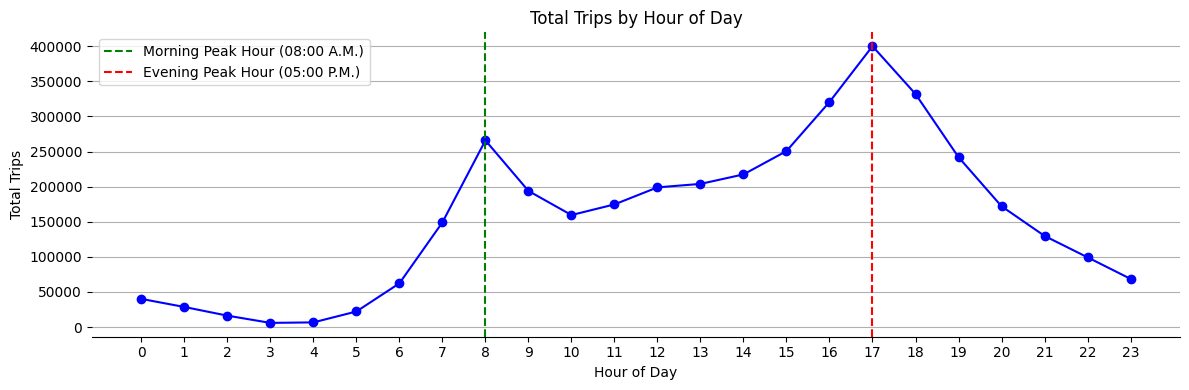

In [23]:
# TOTAL TRIPS PER HOUR OF DAY

# Extract the hours the trips started
combined_df["start_hour"] = combined_df["started_at"].dt.hour

# Group by Hour of Day to calculate total trips
hourly_trip_starts = combined_df.groupby("start_hour").size().reset_index(name="Total Start Trips")

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(hourly_trip_starts["start_hour"], hourly_trip_starts["Total Start Trips"], marker='o', color="blue")

# Set x-axis ticks to show every hour
plt.xticks(range(24))

# Show morning and evening peaks
plt.axvline(x=8, color='green', linestyle='--', label='Morning Peak Hour (08:00 A.M.)')
plt.axvline(x=17, color='red', linestyle='--', label='Evening Peak Hour (05:00 P.M.)')

# Add titles and labels
plt.title("Total Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Trips")

# Remove vertical grid lines
plt.grid(axis='y')

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()

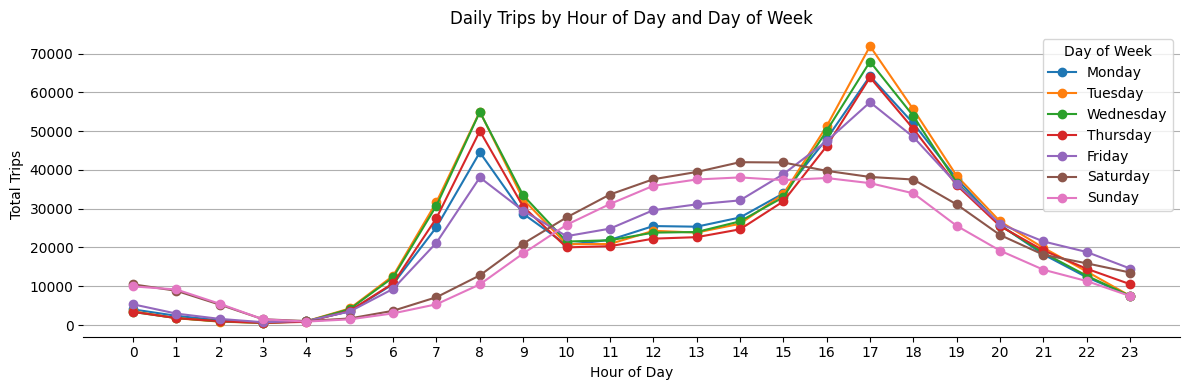

In [24]:
# TOTAL TRIPS PER HOUR OF DAY AND DAY OF WEEK

# Extract the day of the week the trips started
combined_df["start_day_of_week"] = combined_df["started_at"].dt.day_name()

# Group by Day of the Week and Hour of Day to calculate total trips
hourly_weekly_trip_starts = combined_df.groupby(["start_day_of_week", "start_hour"]).size().unstack(fill_value=0)

# Reorder the days of the week for proper visualization
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hourly_weekly_trip_starts = hourly_weekly_trip_starts.reindex(days_order)

# Plotting
plt.figure(figsize=(12, 4))
for day in hourly_weekly_trip_starts.index:
    plt.plot(hourly_weekly_trip_starts.columns, hourly_weekly_trip_starts.loc[day], marker='o', label=day)

plt.xticks(range(24))
plt.title("Daily Trips by Hour of Day and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Total Trips")
plt.grid(axis='y')

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.legend(title="Day of Week")
plt.tight_layout()
plt.show()

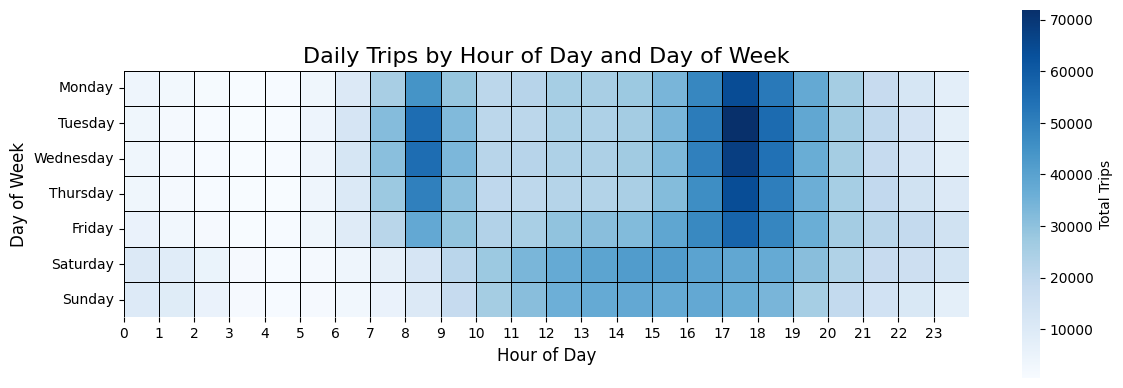

In [25]:
# TOTAL TRIPS PER HOUR OF DAY AND DAY OF WEEK (HEATMAP)

# Plotting
plt.figure(figsize=(12, 4))
sns.heatmap(hourly_weekly_trip_starts, cmap="Blues", annot=False, cbar_kws={'label': 'Total Trips'},
            linewidths=0.5, linecolor='black', square=True)

# Customize the plot
plt.title("Daily Trips by Hour of Day and Day of Week", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)

# Set the x-ticks to show every hour
plt.xticks(ticks=range(24), labels=range(24))

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

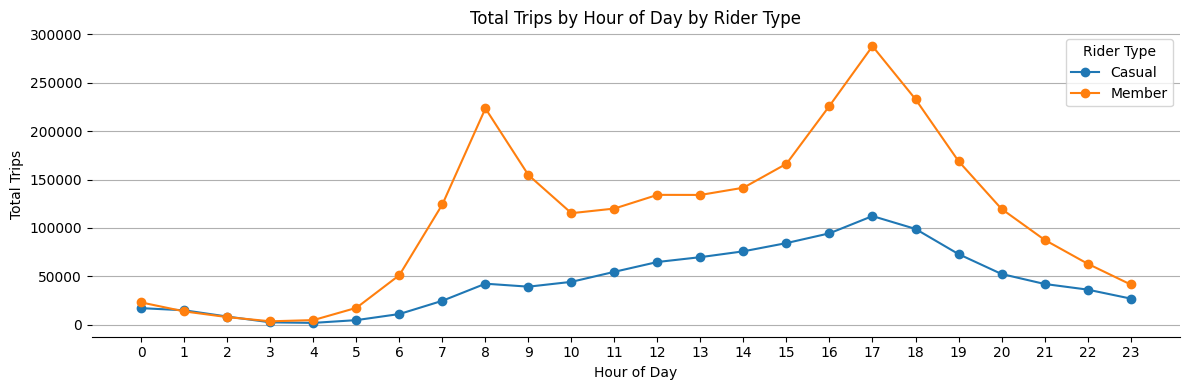

In [26]:
# TOTAL TRIPS PER HOUR OF DAY BY RIDER TYPE

# Group by Hour of Day and Rider Type to calculate total trips
hourly_trip_starts_by_rider_type = combined_df.groupby(["start_hour", "rider_type"]).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 4))

# Plot separate lines for each rider type
for rider_type in hourly_trip_starts_by_rider_type.columns:
    plt.plot(hourly_trip_starts_by_rider_type.index, hourly_trip_starts_by_rider_type[rider_type],
             marker='o', label=rider_type.capitalize())

# Set x-axis ticks to show every hour
plt.xticks(range(24))

# Add titles and labels
plt.title("Total Trips by Hour of Day by Rider Type")
plt.xlabel("Hour of Day")
plt.ylabel("Total Trips")

# Remove vertical grid lines
plt.grid(axis='y')

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.legend(title="Rider Type")
plt.tight_layout()
plt.show()

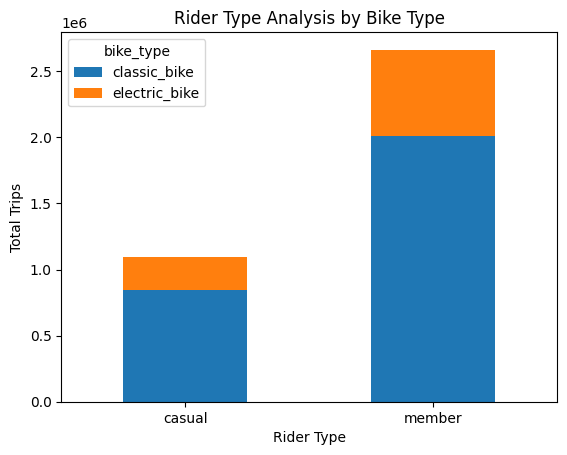

In [27]:
# RIDER TYPE ANALYSIS

rider_type_analysis = combined_df.groupby(['rider_type', 'bike_type']).size().unstack()
rider_type_analysis.plot(kind='bar', stacked=True)
plt.title("Rider Type Analysis by Bike Type")
plt.ylabel("Total Trips")
plt.xlabel("Rider Type")
plt.xticks(rotation=0)
plt.show()

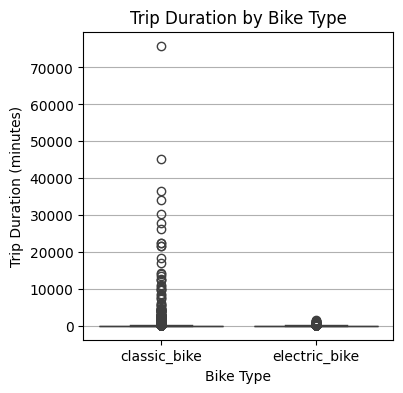

In [28]:
# BOXPLOT FOR TRIP DURATION BY BIKE TYPE

# Calculate trip duration in minutes
combined_df["trip_duration_minutes"] = (combined_df["ended_at"] - combined_df["started_at"]).dt.total_seconds() / 60

plt.figure(figsize=(4, 4))  # Adjust figure size as needed
sns.boxplot(x='bike_type', y='trip_duration_minutes', data=combined_df)
plt.title("Trip Duration by Bike Type")
plt.ylabel("Trip Duration (minutes)")
plt.xlabel("Bike Type")
plt.grid(axis='y')
# Show the plot
plt.show()

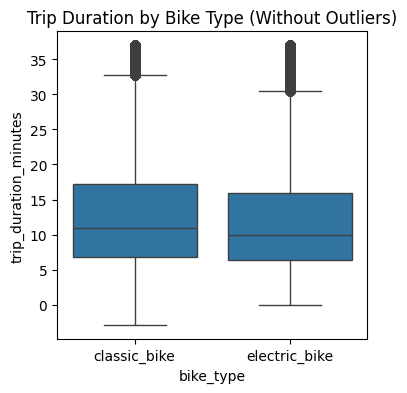

In [29]:
# BOXPLOT FOR TRIP DURATION BY BIKE TYPE WITHOUT OUTLIERS

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['trip_duration_minutes'].quantile(0.25)
Q3 = combined_df['trip_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to exclude outliers
filtered_df = combined_df[(combined_df['trip_duration_minutes'] >= lower_bound) & (combined_df['trip_duration_minutes'] <= upper_bound)]

# Boxplot for Trip Duration by Bike Type without outliers
plt.figure(figsize=(4, 4))
sns.boxplot(x='bike_type', y='trip_duration_minutes', data=filtered_df)
plt.title("Trip Duration by Bike Type (Without Outliers)")
plt.show()

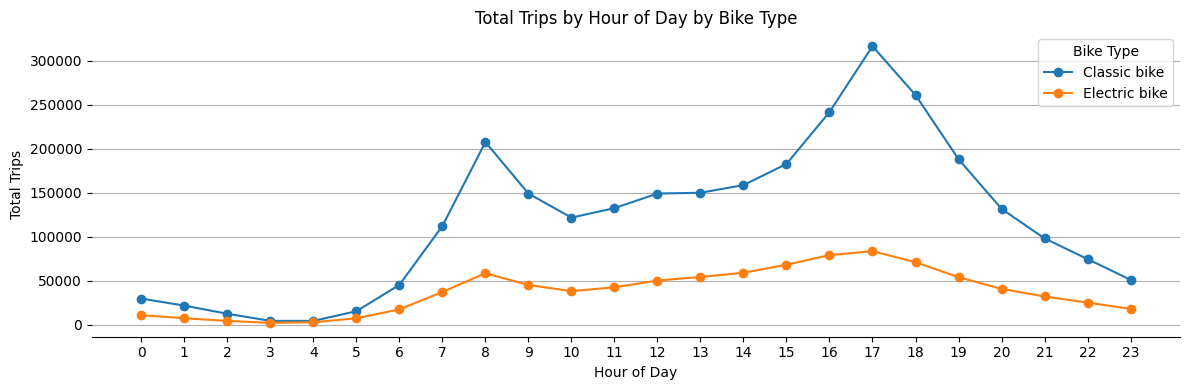

In [30]:
# TOTAL TRIPS PER HOUR OF DAY BY BIKE TYPE

# Group by Hour of Day and Bike Type to calculate total trips
hourly_trip_starts_by_bike_type = combined_df.groupby(["start_hour", "bike_type"]).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 4))

# Plot separate lines for each bike type
for bike_type in hourly_trip_starts_by_bike_type.columns:
    plt.plot(hourly_trip_starts_by_bike_type.index, hourly_trip_starts_by_bike_type[bike_type],
             marker='o', label=bike_type.replace("_", " ").capitalize())

# Set x-axis ticks to show every hour
plt.xticks(range(24))

# Add titles and labels
plt.title("Total Trips by Hour of Day by Bike Type")
plt.xlabel("Hour of Day")
plt.ylabel("Total Trips")

# Remove vertical grid lines
plt.grid(axis='y')

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.legend(title="Bike Type")
plt.tight_layout()
plt.show()

In [31]:
# Filter the trip durations for electric and classic bikes
electric_durations = combined_df[combined_df["bike_type"] == "electric_bike"]["trip_duration_minutes"]
classic_durations = combined_df[combined_df["bike_type"] == "classic_bike"]["trip_duration_minutes"]

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(electric_durations, classic_durations)

# Output the result
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -27.591784105743642, P-value: 1.4512695433160166e-167


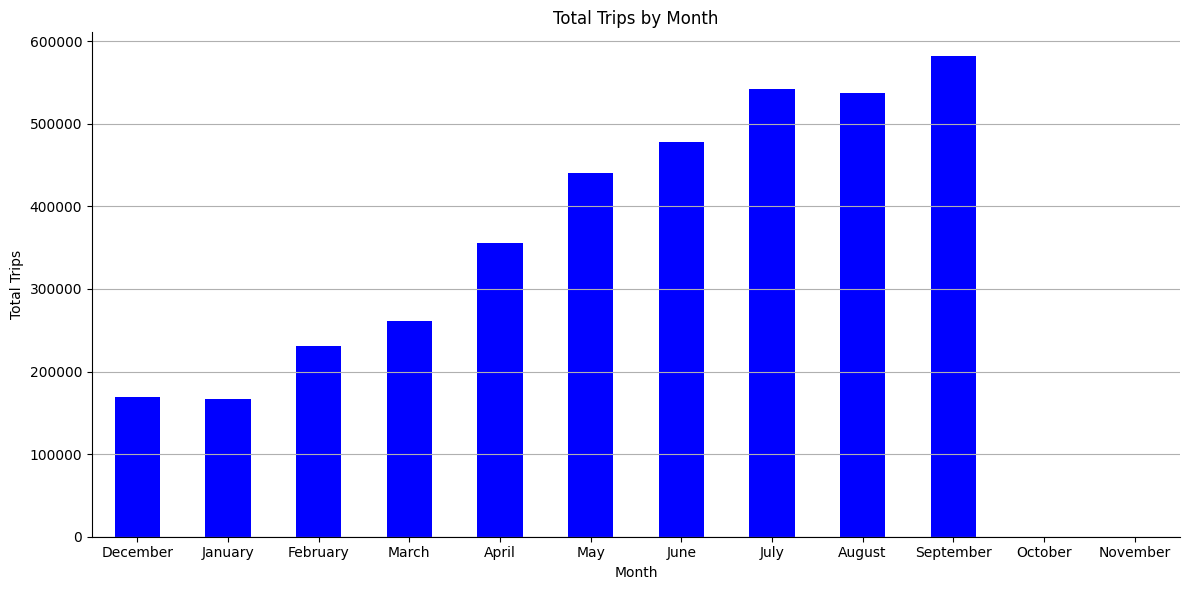

In [32]:
# Extract the month the trips started
combined_df["start_month"] = combined_df["started_at"].dt.month_name()

# Count total trips by month
monthly_trip_counts = combined_df["start_month"].value_counts().reindex(
    ["December", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November"],
    fill_value=0)

# Create a time series plot for total trips by month
plt.figure(figsize=(12, 6))
monthly_trip_counts.plot(kind='bar', color='blue')

plt.title("Total Trips by Month")
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.xticks(rotation=0)

# Add a horizontal line at y=0 for better visibility
plt.axhline(0, color='gray', linewidth=0.8)

# Grid for easier reading
plt.grid(axis='y')

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [33]:
combined_df.head()

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type,start_hour,start_day_of_week,trip_duration_minutes,start_month
0,31F12D722DEC2205,classic_bike,2023-12-01 00:00:47,2023-12-01 00:18:32,MIT Carleton St at Amherst St,M32070,Lower Cambridgeport at Magazine St / Riverside Rd,M32022,42.360541,-71.086698,42.357219,-71.113872,member,0,Friday,17.750000,December
1,C7B5105B0B65C0F3,classic_bike,2023-12-01 00:02:04,2023-12-01 00:07:54,MIT at Mass Ave / Amherst St,M32006,MIT Vassar St,M32042,42.358100,-71.093198,42.355601,-71.103945,member,0,Friday,5.833333,December
2,68B5F2A512F98D31,classic_bike,2023-12-01 00:02:11,2023-12-01 00:03:15,South Station - 700 Atlantic Ave,A32010,Boston Landing,A32045,42.352175,-71.055547,42.356561,-71.141675,member,0,Friday,1.066667,December
3,498C4A8C729ED986,classic_bike,2023-12-01 00:04:19,2023-12-01 00:14:00,One Beacon St,B32061,Columbus Ave at W. Canton St,C32077,42.358477,-71.061351,42.344742,-71.076482,member,0,Friday,9.683333,December
4,2B9A06F84509E2C0,classic_bike,2023-12-01 00:04:38,2023-12-01 00:16:16,Silber Way,D32032,Dartmouth St at Newbury St,D32045,42.349495,-71.100575,42.350961,-71.077828,member,0,Friday,11.633333,December
